<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/qf-workshop-2021/introduction-to-machine-learning/blob/main/1_notebooks/introduction-to-machine-learning.ipynb">
        <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
</table>

# Supervised and Unsupervised Models

## Linear Regression

A linear model makes a prediction by simply computing a weighted
sum of the input features, plus a constant called the *bias* term (also called the *intercept*
term):

\begin{equation}
\hat y = \theta_0 + \theta_1 x_1 + \theta_2 x_2 + \dots + \theta_n x_n
\end{equation}

where:

- $\hat y$ is the predicted value;
- $n$ is the number of features;
- $x_i$ is the $i^{th}$ feature value;
- $\theta_j$ is the $j^{th}$ model parameter (including the bias term $\theta_0$ and the feature weights $\theta_1, \theta_2, \dots, \theta_n$

Training a model means setting its parameters so that the model best fits the training set. For this purpose, we first need a measure of how well (or poorly) the model fits the training data. The most common performance measure of a regression model is the Root Mean Square Error (RMSE), therefore, to train a Linear Regression model, you need to find the value of $\theta$ that minimizes the RMSE. In practice, it is simpler to minimize the Mean Square Error (MSE) than the RMSE, and it leads to the same result.


### Example 1 - Predicting Iowa House Prices (from Kaggle)

In [1]:
# loading packages 

import os

import pandas as pd
import numpy as np

# plotting packages
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as clrs

# Kmeans algorithm from scikit-learn
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

#### The Problem

The objective is to predict the prices of house in Iowa from features. We have 800 observations in training set, 600 in validation set, and 508 in test set

#### Categorical Features

Categorical features are features where there are a number of non-numerical alternatives. We can define a dummy variable for each alternative. The variable equals 1 if the alternative is true and zero otherwise. This is known as **one-hot encoding**.
But sometimes we do not have to do this because there is a natural ordering of variables. For example in this problem one of the categorical features is concerned with the basement quality as indicated by the ceiling height. The categories are:

- *Excellent (< 100 inches)*
- *Good (90-99 inches)*
- *Typical (80-89 inches)*
- *Fair (70-79 inches)*
- *Poor (< 70 inches)*
- *No Basement*

This is an example of a categorical variable where *there is* a natural ordering. We created a new variable that had a values of 5, 4, 3, 2, 1 and 0 for the above six categories respectively.

The other categorical features specifies the location of the house as in one of 25 neighborhoods. We introduce 25 dummy variables with a one-hot encoding. The dummy variable equals one for an observation if the neighborhood is that in which the house is located and zero otherwise.

#### Loading data (J. C. Hull, 2019, Chapter 3)

To illustrate the regression techniques discussed in this chapter we will use a total of 48 feature. 21 are numerical and two are categorical and to this we had, as discussed above, 25 categorical variables for the neighborhoods. 

In [2]:
if 'google.colab' in str(get_ipython()):
    from google.colab import files
    uploaded = files.upload()
    path = ''
else:
    path = './data/'

In [3]:
# Both features and target have already been scaled: mean = 0; SD = 1
data = pd.read_csv(path + 'Houseprice_data_scaled.csv') 
data.head()

,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,...,OLDTown,SWISU,Sawyer,SawyerW,Somerst,StoneBr,Timber,Veenker,Bsmt Qual,Sale Price
0,-0.199572,0.652747,-0.512407,1.038851,0.875754,0.597837,-0.937245,-0.482464,-0.808820,1.203988,...,-0.286942,-0.136621,-0.2253,-0.214192,-0.268378,-0.127929,-0.152629,-0.091644,0.584308,0.358489
1,-0.072005,-0.072527,2.189741,0.136810,-0.432225,1.218528,-0.635042,0.490326,0.276358,-0.789421,...,-0.286942,-0.136621,-0.2253,-0.214192,-0.268378,-0.127929,-0.152629,10.905682,0.584308,0.008849
2,0.111026,0.652747,-0.512407,0.972033,0.827310,0.095808,-0.296754,-0.329118,-0.637758,1.231999,...,-0.286942,-0.136621,-0.2253,-0.214192,-0.268378,-0.127929,-0.152629,-0.091644,0.584308,0.552733
3,-0.077551,0.652747,-0.512407,-1.901135,-0.722887,-0.520319,-0.057698,-0.722067,-0.528171,0.975236,...,-0.286942,-0.136621,-0.2253,-0.214192,-0.268378,-0.127929,-0.152629,-0.091644,-0.577852,-0.528560
4,0.444919,1.378022,-0.512407,0.938624,0.730423,0.481458,-0.170461,0.209990,-0.036366,1.668495,...,-0.286942,-0.136621,-0.2253,-0.214192,-0.268378,-0.127929,-0.152629,-0.091644,0.584308,0.895898


First of all check how many records we have

In [4]:
print("Number of available data = "  + str(len(data.index)))

Number of available data = 2908


Before starting we emphasize the need to divide all available data into three parts: a **training set**, a **validation set** and a **test set**. The training set is used to determine parameters for trial models. The validation set is used to determine the extent to chich the models created from the training set generalize to new data. Finally, the test set is used as a final estimate of the accuracy of the chosen model. 

We had 2908 observations. We split this as follows: 1800 in the training set, 600 in the validation set and 508 in the test set.

In [5]:
# First 1800 data items are training set; the next 600 are the validation set
train = data.iloc[:1800] 
val = data.iloc[1800:2400]

We now procede to create **labels** and **features**. As we have already said, the labels are the values of the target that is to be predicted, in this case the 'Sale Price', and we indicate that whit 'y':

In [6]:
y_train, y_val = train[['Sale Price']], val[['Sale Price']] 

The features and dummy variables were scaled using the Z-score method. Also the target values (i.e. the house prices) have been scaled with the Z-score method. The features are the variables from which the predictions are to be made and, in this case, can be obtained simply dropping the column 'Sale Price' from our dataset:

In [7]:
X_train, X_val = train.drop('Sale Price', axis=1), val.drop('Sale Price', axis=1)

In [8]:
X_train.columns

Index(['LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'BsmtFinSF1', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'GrLivArea', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', 'Blmngtn', 'Blueste', 'BrDale', 'BrkSide', 'ClearCr',
       'CollgCr', 'Crawfor', 'Edwards', 'Gilbert', 'IDOTRR', 'MeadowV',
       'Mitchel', 'Names', 'NoRidge', 'NPkVill', 'NriddgHt', 'NWAmes',
       'OLDTown', 'SWISU', 'Sawyer', 'SawyerW', 'Somerst', 'StoneBr', 'Timber',
       'Veenker', 'Bsmt Qual'],
      dtype='object')

#### Linear Regression with sklearn

In [9]:
# Importing models
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as mse

In [10]:
lr = LinearRegression()
lr.fit(X_train,y_train)

LinearRegression()

In [11]:
lr.intercept_

array([-3.06335941e-11])

In [12]:
coeffs = pd.DataFrame(
    [
        ['intercept'] + list(X_train.columns),
        list(lr.intercept_) + list(lr.coef_[0])
    ]
)
coeffs

,0,1,2,3,4,5,6,7,8,9,...,38,39,40,41,42,43,44,45,46,47
0,intercept,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,1stFlrSF,...,NWAmes,OLDTown,SWISU,Sawyer,SawyerW,Somerst,StoneBr,Timber,Veenker,Bsmt Qual
1,-3.06336e-11,0.0789996,0.214395,0.0964787,0.160799,0.0253524,0.0914664,-0.0330798,0.138199,0.152786,...,-0.0517591,-0.026499,-0.00414298,-0.0181341,-0.0282754,0.0275063,0.0630586,-0.00276173,0.00240311,0.0113115


In [13]:
# Create dataFrame with corresponding feature and its respective coefficients
coeffs = pd.DataFrame(
    [
        ['intercept'] + list(X_train.columns),
        list(lr.intercept_) + list(lr.coef_[0])
    ]
).transpose().set_index(0)
coeffs

,1
0,
intercept,-3.06336e-11
LotArea,0.0789996
OverallQual,0.214395
OverallCond,0.0964787
YearBuilt,0.160799
YearRemodAdd,0.0253524
BsmtFinSF1,0.0914664
BsmtUnfSF,-0.0330798
TotalBsmtSF,0.138199


In [14]:
len(coeffs.index)

48

In [15]:
pred_t=lr.predict(X_train)
mse(y_train,pred_t)

0.11401526431246334

In [16]:
pred_v=lr.predict(X_val)
mse(y_val,pred_v)

0.11702499460121657

For the data we are considering it turns out that this regression model generalizes well. The mean squared error for the validation set was only a little higher than that for the training set. However linear regression with no regularization leads to some strange results because of the correlation between features. For example it makes no sense that the weights for number of full bathrooms and number of bedrooms are negative!

In [17]:
x1 = X_train['GrLivArea']
x2 = X_train['BedroomAbvGr']
x1.corr(x2)

0.5347396038733939

###### Ridge Regression

In [18]:
# Importing Ridge
from sklearn.linear_model import Ridge

We try using Ridge regression with different values of the hyperparameter $\lambda$. The following code shows the effect of this parameter on the prediction error. 

In [19]:
# The alpha used by Python's ridge should be the lambda in Hull's book times the number of observations
alphas=[0.01*1800, 0.02*1800, 0.03*1800, 0.04*1800, 0.05*1800, 0.075*1800,0.1*1800,0.2*1800, 0.4*1800]
mses=[]
for alpha in alphas:
    ridge=Ridge(alpha=alpha)
    ridge.fit(X_train,y_train)
    pred=ridge.predict(X_val)
    mses.append(mse(y_val,pred))
    print(mse(y_val,pred))

0.11703284346091342
0.11710797319752984
0.11723952924901117
0.11741457158889518
0.1176238406871145
0.11825709631198021
0.11900057469147927
0.1225464999629295
0.13073599680747128


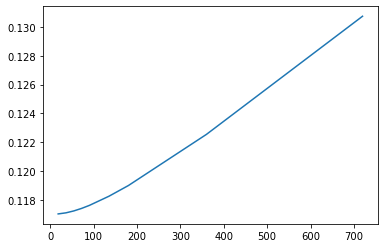

In [20]:
plt.plot(alphas, mses)

As expected the prediction error increases as $\lambda$ increases. Values of $\lambda$ in the range $0$ to $0.1$ might be reasonably be considered because prediction errors increases only slightly when $\lambda$ is in this range. However it turns out that the improvement in the model is quite small for these values of $\lambda$.

###### Lasso

In [21]:
# Import Lasso
from sklearn.linear_model import Lasso

In [22]:
# Here we produce results for alpha=0.05 which corresponds to lambda=0.1 in Hull's book
lasso = Lasso(alpha=0.05)
lasso.fit(X_train, y_train)

Lasso(alpha=0.05)

In [23]:
# DataFrame with corresponding feature and its respective coefficients
coeffs = pd.DataFrame(
    [
        ['intercept'] + list(X_train.columns),
        list(lasso.intercept_) + list(lasso.coef_)
    ]
).transpose().set_index(0)
coeffs

,1
0,
intercept,-1.25303e-11
LotArea,0.0443042
OverallQual,0.298079
OverallCond,0
YearBuilt,0.0520907
YearRemodAdd,0.0644712
BsmtFinSF1,0.115875
BsmtUnfSF,-0
TotalBsmtSF,0.10312


###### Lasso with different levels of alpha and its mse

In [24]:
# We now consider different lambda values. The alphas are half the lambdas
alphas=[0.01/2, 0.02/2, 0.03/2, 0.04/2, 0.05/2, 0.06/2, 0.08/2, 0.09/2, 0.1/2]
mses=[]
for alpha in alphas:
    lasso=Lasso(alpha=alpha)
    lasso.fit(X_train,y_train)
    pred=lasso.predict(X_val)
    mses.append(mse(y_val,pred))
    print("lambda = " + '{:<05}'.format(alpha) + " - mse = " + str(round(mse(y_val, pred),6)))

lambda = 0.005 - mse = 0.116548
lambda = 0.010 - mse = 0.116827
lambda = 0.015 - mse = 0.118033
lambda = 0.020 - mse = 0.120128
lambda = 0.025 - mse = 0.123015
lambda = 0.030 - mse = 0.126462
lambda = 0.040 - mse = 0.133492
lambda = 0.045 - mse = 0.137016
lambda = 0.050 - mse = 0.140172


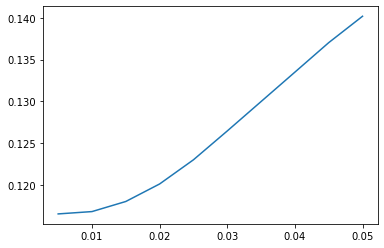

In [25]:
plt.plot(alphas, mses)

Lasso regression leads to more interesting results. In the plot above you can see how the error in the validation set changes as tha value of the lasso $\lambda$ increases. For small values of $\lambda$ the error is actually less than when $\lambda = 0$ but as $\lambda$ increases beyond about $0.03$ the error starts to increase. A value of $\lambda = 0.04$ could be chosen.   

## References

John C. Hull, **Machine Learning in Business: An Introduction to the World of Data Science**, Amazon, 2019.

Paul Wilmott, **Machine Learning: An Applied Mathematics Introduction**, Panda Ohana Publishing, 2019.